In [4]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects


#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

In [5]:
from keras_unet_collection import models

In [6]:
ds_train_xr = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Training_data/train.nc')

ds_val_xr = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Training_data/validate.nc')
                                         

In [ ]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((ds_train_xr.features.values,ds_train_xr.labels_2d.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val_xr.features.values,ds_val_xr.labels_2d.values))

# #shuffle only the training
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 64
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

In [64]:
for batch in ds_train:
    break 

2023-10-16 20:36:48.723477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1330,256,32,8]
	 [[{{node Placeholder/_0}}]]
2023-10-16 20:36:48.723971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1330,256,32]
	 [[{{node Placeholder/_1}}]]


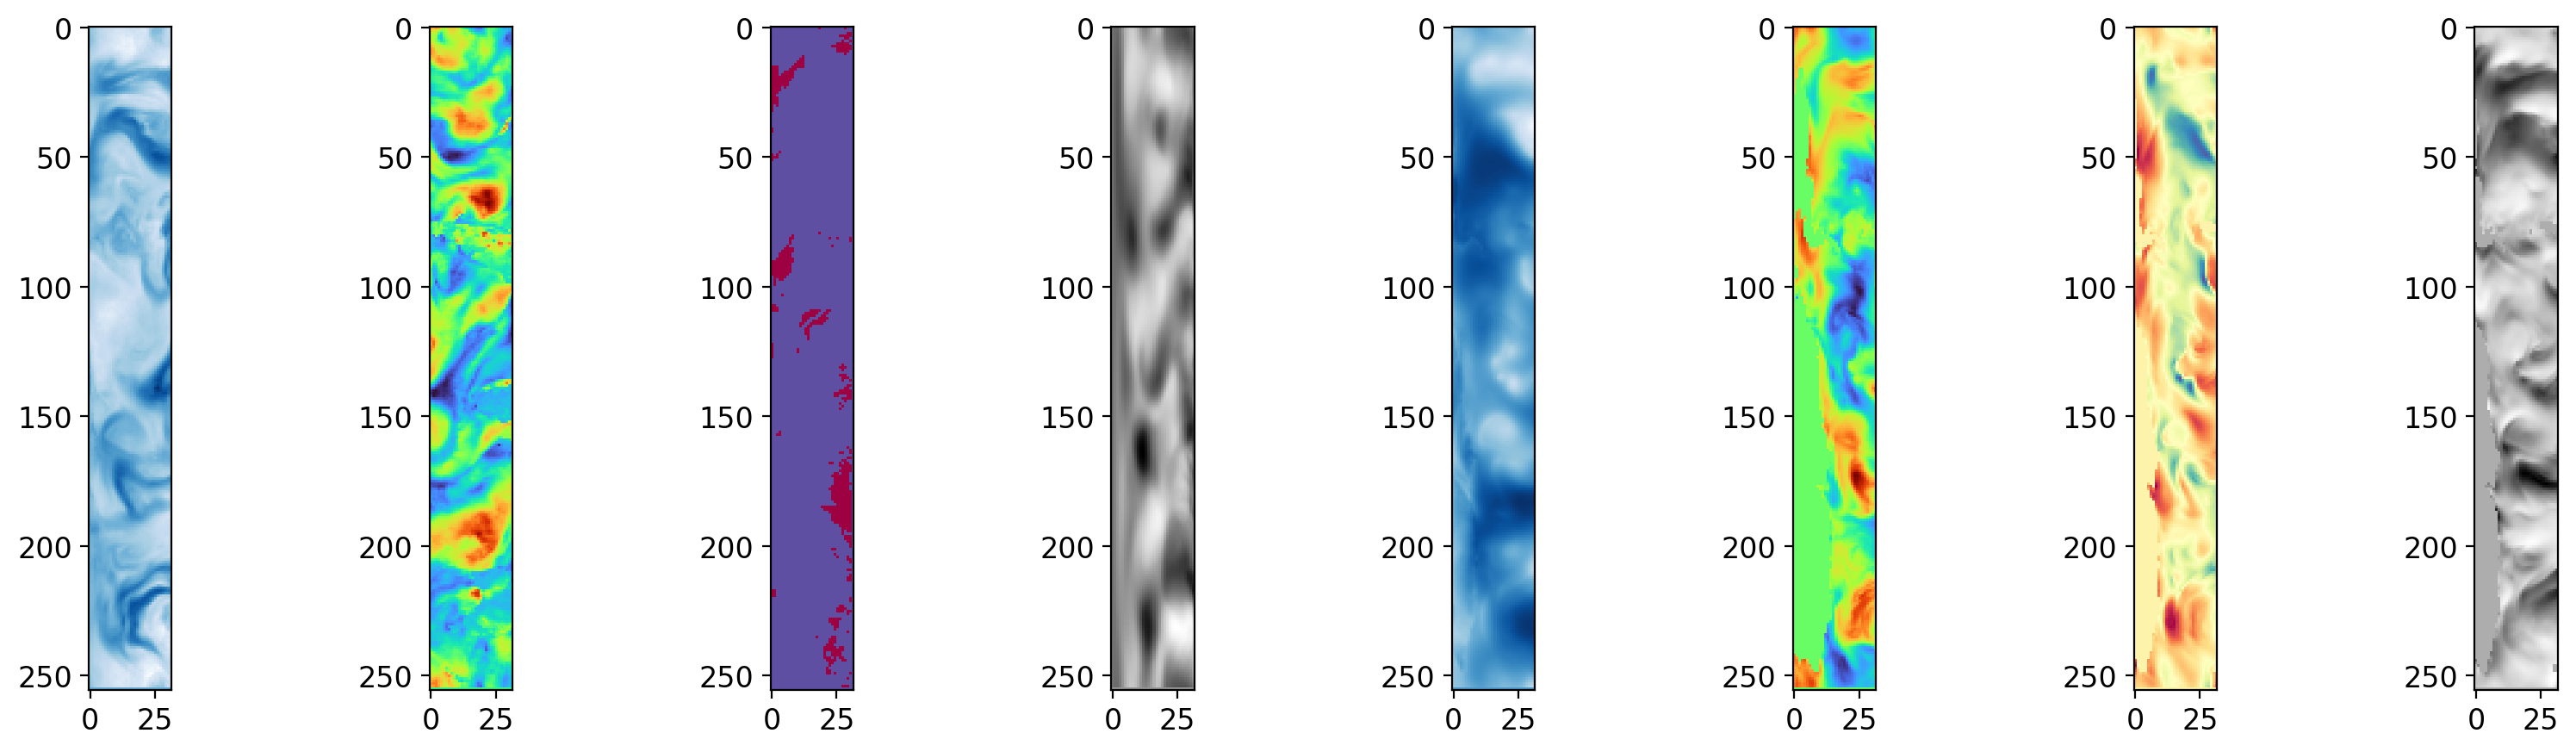

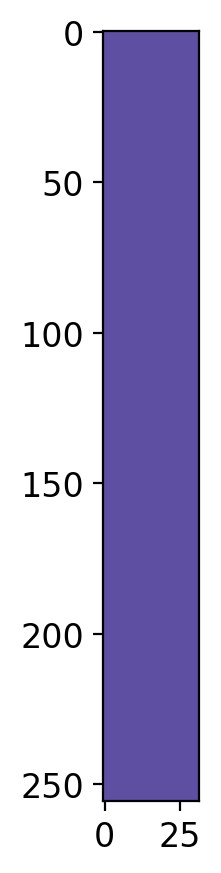

In [65]:
#get the features for example 12 in this batch 
one_example_features = batch[0][10]
#get the label for that same example 
one_example_label = batch[1][10]


fig,axes = plt.subplots(1,8,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')
axes[4].imshow(one_example_features[:,:,4],cmap='Blues')
axes[5].imshow(one_example_features[:,:,5],cmap='turbo')
axes[6].imshow(one_example_features[:,:,6],cmap='Spectral_r')
axes[7].imshow(one_example_features[:,:,7],cmap='Greys_r')

fig,axes = plt.subplots(1,1,figsize=(4,5))
axes.imshow(one_example_label, cmap = 'Spectral_r')

## Build Model

In [69]:
model = models.unet_2d([256, 32, 8],[2,4],1,stack_num_down=1,stack_num_up=1,output_activation='Sigmoid',weights=None)

In [70]:
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 32, 8)  0           []                               
                                ]                                                                 
                                                                                                  
 unet_down0_0 (Conv2D)          (None, 256, 32, 2)   146         ['input_5[0][0]']                
                                                                                                  
 unet_down0_0_activation (ReLU)  (None, 256, 32, 2)  0           ['unet_down0_0[0][0]']           
                                                                                                  
 unet_down1_encode_maxpool (Max  (None, 128, 16, 2)  0           ['unet_down0_0_activatio

9/9 [==============================] - 0s 39ms/step


(0.0, 1.0)

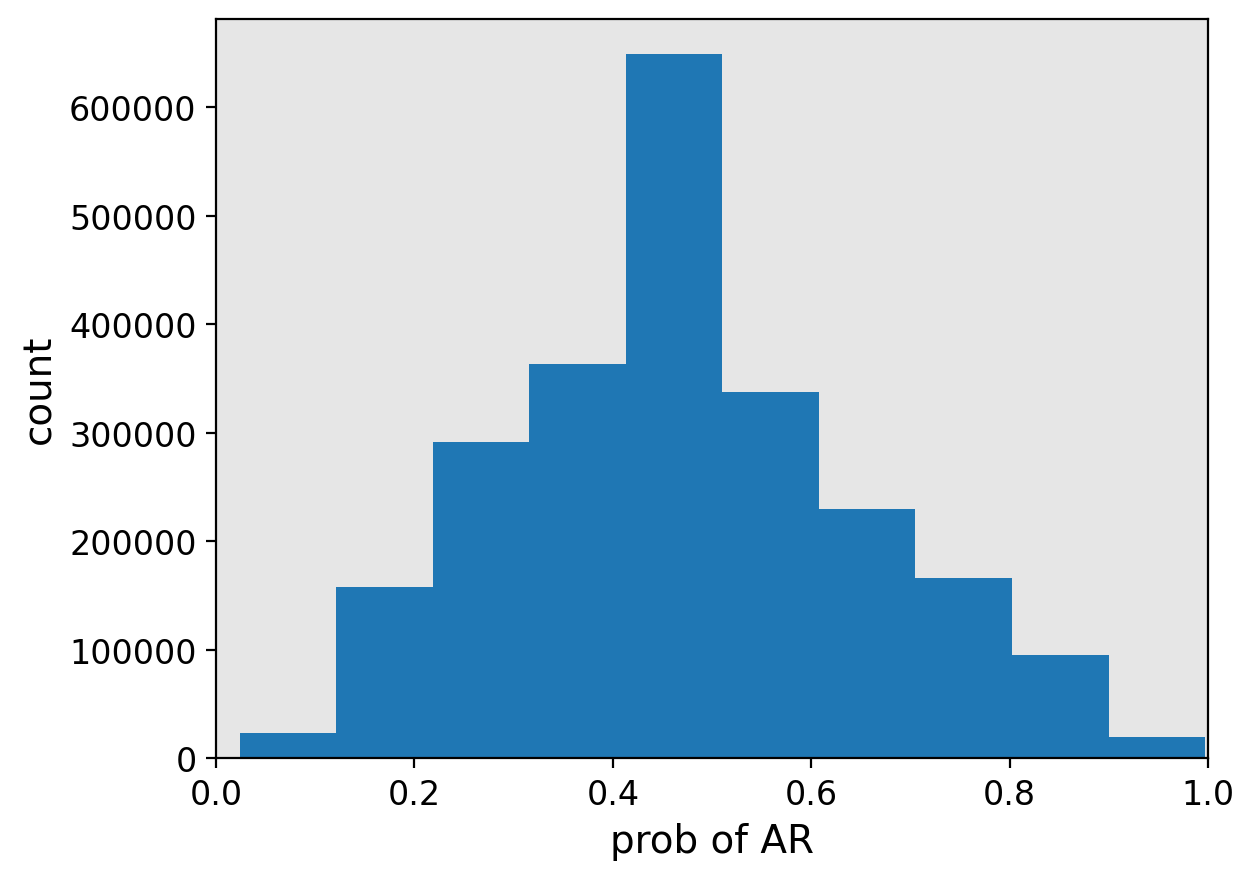

In [71]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.hist(y_preds.ravel())
plt.xlabel('prob of AR')
plt.ylabel('count')
plt.xlim([0,1])

In [72]:
#grab a batch to look at 
for batch in ds_val:
    break 

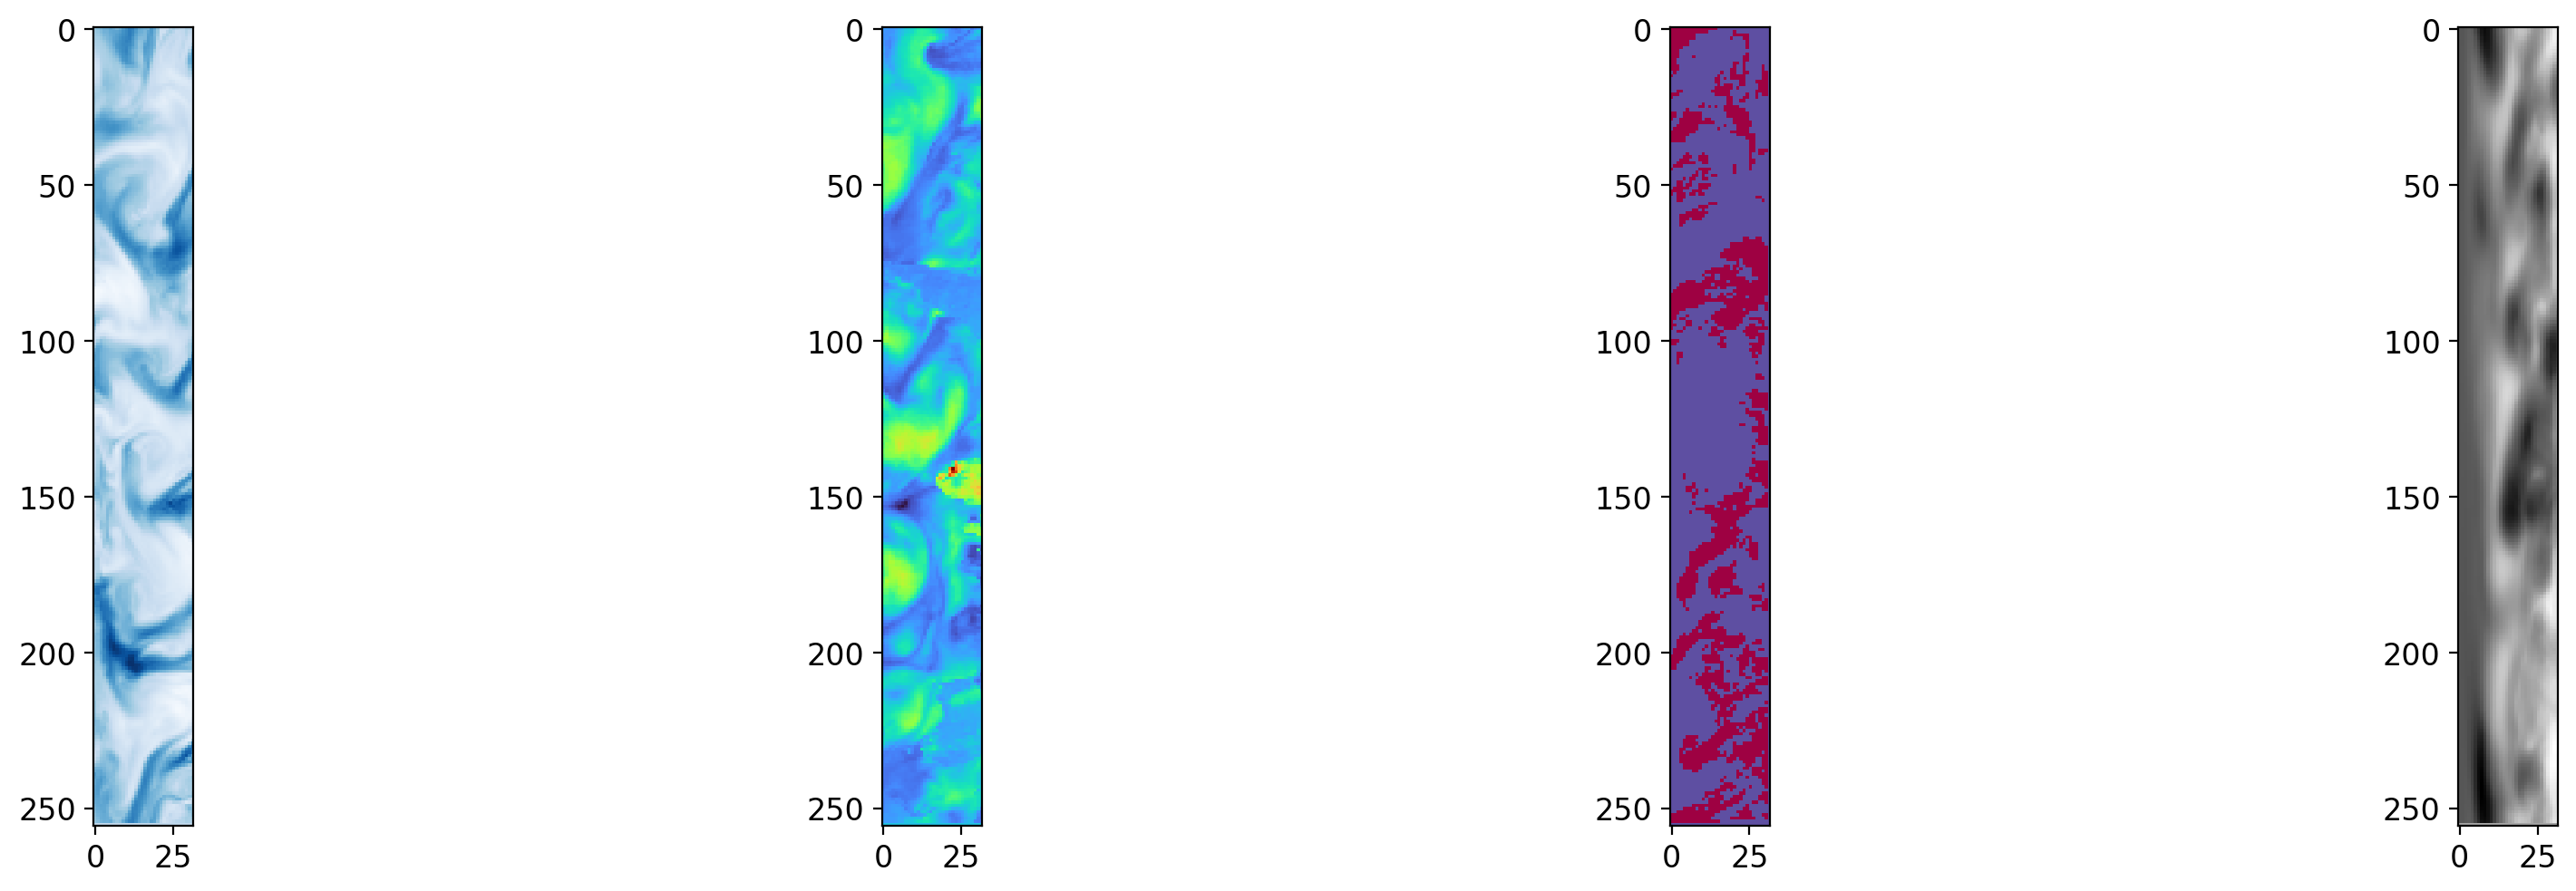

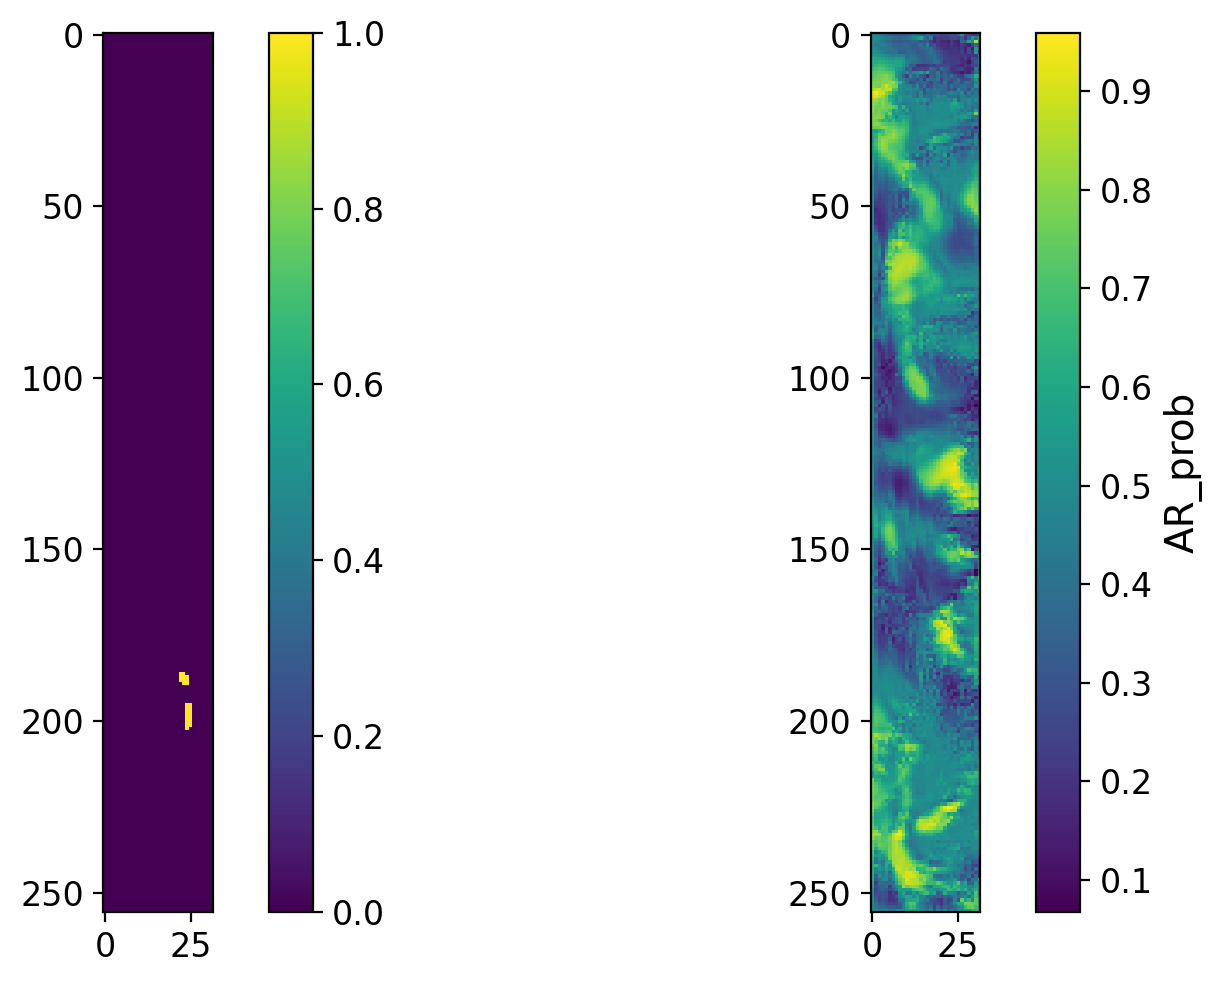

In [73]:
#get the features for example 12 in this batch 
one_example_features = batch[0][10]
#get the label for that same example 
one_example_label = batch[1][10]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5))
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(y_preds[27])
plt.colorbar(pm,ax=axes[1],label='AR_prob')


plt.tight_layout()

## Train

In [74]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

history = model.fit(ds_train,validation_data=ds_val,epochs=30)


Epoch 1/30
42/42 [==============================] - 10s 224ms/step - loss: 0.3805 - val_loss: 0.1359
Epoch 2/30
42/42 [==============================] - 9s 212ms/step - loss: 0.0780 - val_loss: 0.0636
Epoch 3/30
42/42 [==============================] - 9s 216ms/step - loss: 0.0582 - val_loss: 0.0592
Epoch 4/30
42/42 [==============================] - 9s 225ms/step - loss: 0.0550 - val_loss: 0.0563
Epoch 5/30
42/42 [==============================] - 9s 213ms/step - loss: 0.0523 - val_loss: 0.0538
Epoch 6/30
42/42 [==============================] - 9s 214ms/step - loss: 0.0500 - val_loss: 0.0513
Epoch 7/30
42/42 [==============================] - 9s 203ms/step - loss: 0.0479 - val_loss: 0.0492
Epoch 8/30
42/42 [==============================] - 9s 219ms/step - loss: 0.0461 - val_loss: 0.0474
Epoch 9/30
42/42 [==============================] - 10s 226ms/step - loss: 0.0447 - val_loss: 0.0463
Epoch 10/30
42/42 [==============================] - 9s 209ms/step - loss: 0.0437 - val_loss: 0.04

9/9 [==============================] - 0s 39ms/step


(0.0, 1.0)

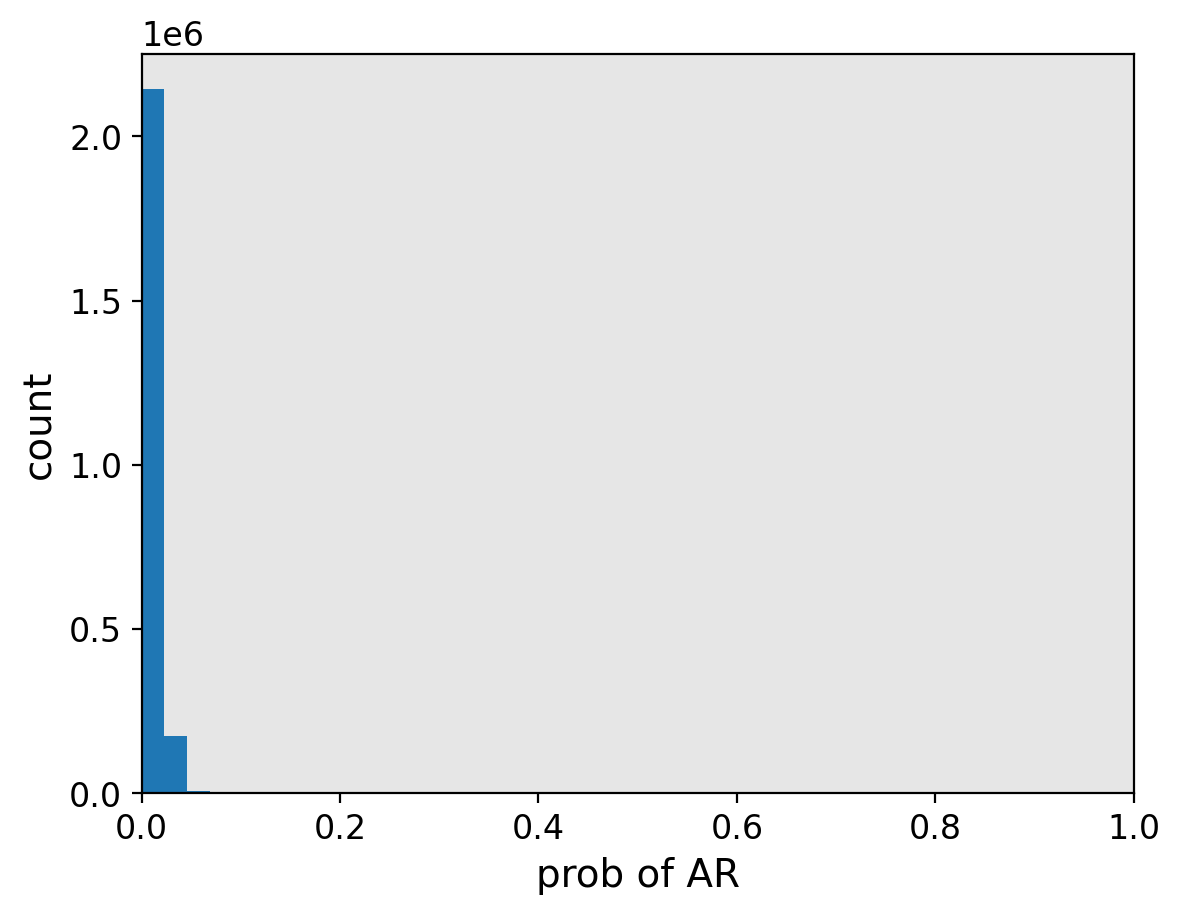

In [75]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.hist(y_preds.ravel())
plt.xlabel('prob of AR')
plt.ylabel('count')
plt.xlim([0,1])

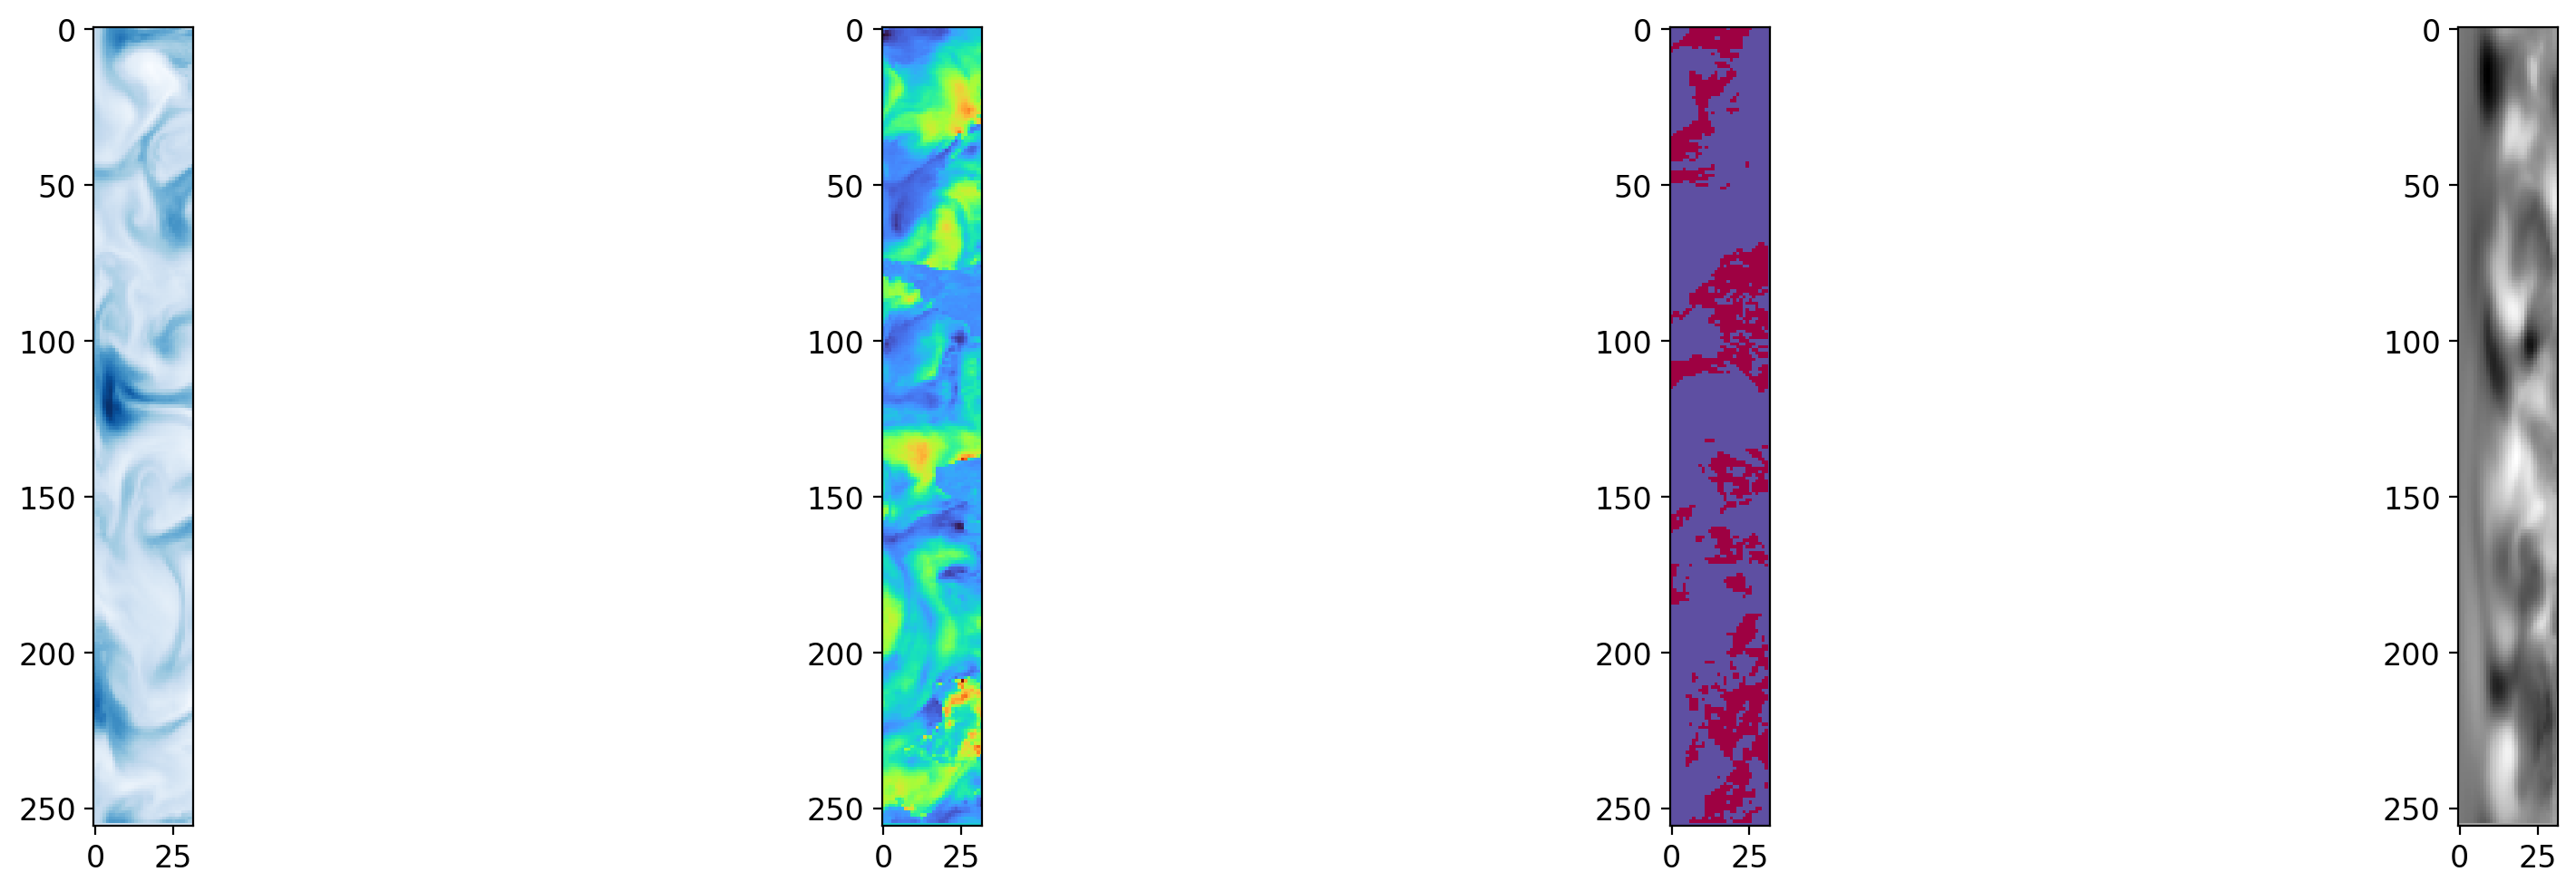

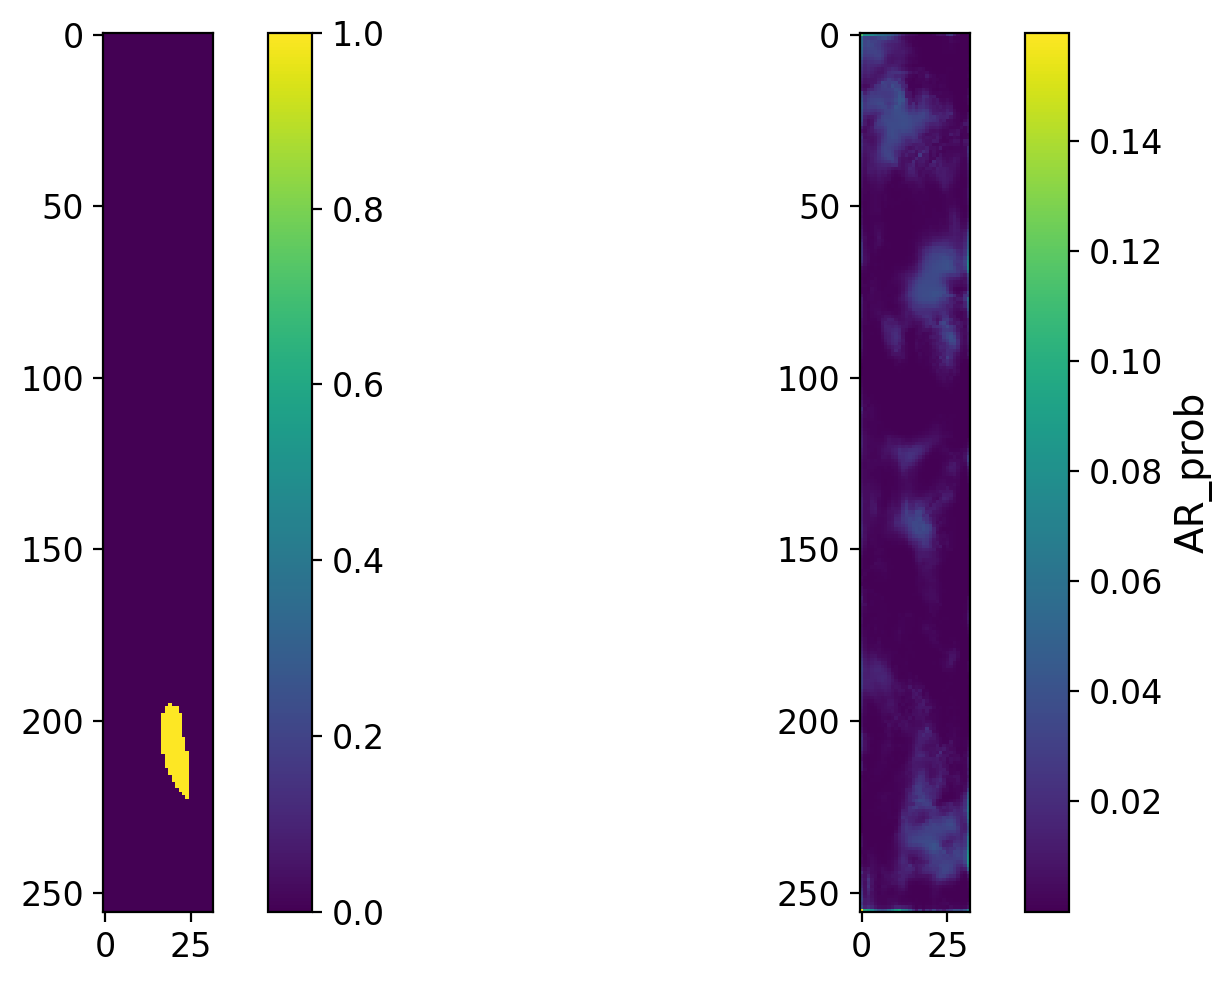

In [76]:
#get the features for example 12 in this batch 
one_example_features = batch[0][5]
#get the label for that same example 
one_example_label = batch[1][5]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5),facecolor='w')
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(y_preds[27])
plt.colorbar(pm,ax=axes[1],label='AR_prob')


plt.tight_layout()

## Evaluate

In [77]:
import copy 
for i,(_,y) in enumerate(ds_val):
    if i == 0:
        y_v = copy.deepcopy(y)
    else:
        y_v = np.concatenate([y_v,y])

#ravel both
y_v_rav = y_v.ravel()
y_preds_rav = y_preds.ravel()

In [78]:
#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v_rav,y_preds_rav)
fps = fp(y_v_rav,y_preds_rav)
fns = fn(y_v_rav,y_preds_rav)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

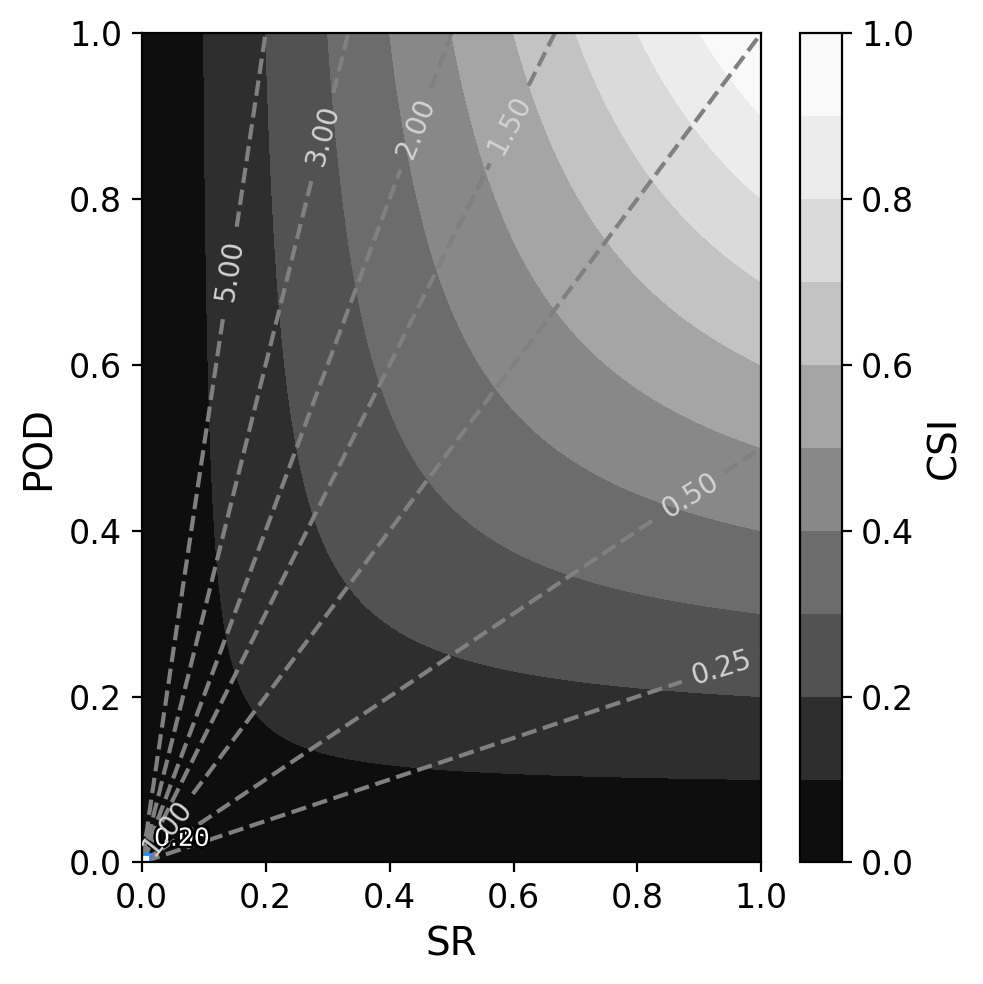

In [79]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()